# Lecture 4: Variance Reduction Methods for Monte Carlo Estimation
AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University


In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

C:\Users\vkaynig\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Control Variates Example:

In this example we would like to estimate the integral of the function $f(x) = \cos(x) \exp(-x)+0.2  $ from 0 to 10. 

$$ I = \int_{0}^{10} dx [\cos(x) \exp(-x)+0.2] $$

and we introduce a control variate $g(x) =exp(-x)+0.2 $. This function is chosen such 
as the correlation of $f,g$ is close to one.

In [2]:
# bounds of our integral
xmax = 10
xmin = 0

# number of samples
N=10000

# ==================================
# function definitions 
# =================================
f = lambda x: np.cos(x)*np.exp(-x)+0.2;
g = lambda x: np.exp(-x)+0.2;
# anti-derivative for testing 
fint = lambda z: z/5.0+ 0.5*np.exp(-z)*(np.sin(z)-np.cos(z))
# anit-derivative to estimate tau
fint_vr = lambda z: z/5.0 - 1/np.exp(z)  
 

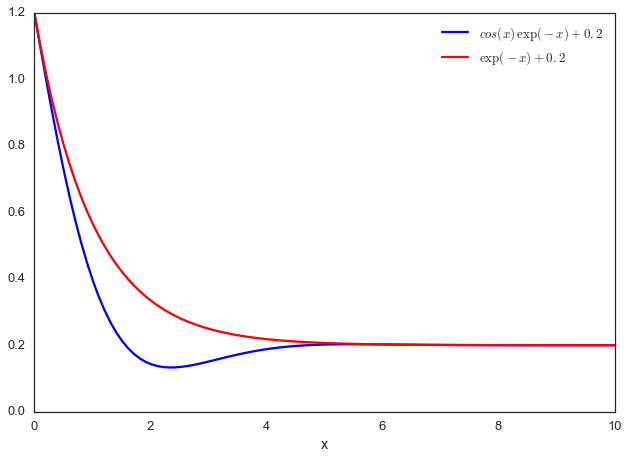

In [11]:
# ============================
# plot the functions
# ============================
x = np.linspace(0,10, 100)

plt.plot(x, f(x), 'b', label=u'$cos(x)\, \exp(-x)+0.2$') 
plt.plot( x, g(x), 'r', label = u'$\exp(-x)+0.2$')
plt.xlabel("x")
plt.legend()
plt.show()

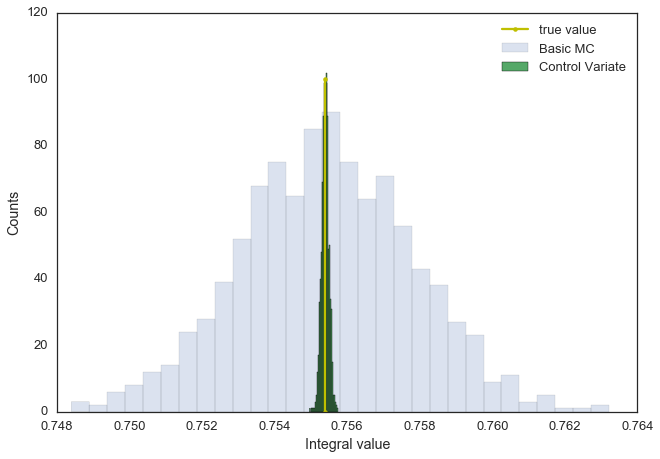

std dev of vanilla monte carlo:  0.00239814647132
std dev with control variate:  0.000104954976054


In [12]:
# I_vanilla_monte_carlo
Ivmc = np.zeros(1000)
# I_variance_reduced
Imc_vr = np.zeros(1000)

# exact value for testing
true_val = fint(xmax) - fint(xmin)
# our exact tau
tau =(1.0/(xmax-xmin))*(fint_vr(xmax)-fint_vr(xmin));

for k in np.arange(0,1000):
    
    # ----------------------
    # lets do the normal MC
    # ----------------------  
    X = np.random.uniform( low=xmin, high=xmax, size=N)
    Ivmc[k] = (xmax-xmin)*np.mean(f(X));

    # ----------------------
    # CONTROL VARIATE
    # ----------------------
    
    # compute optimal value for b
    q = np.cov(g(X),f(X));  
    b =- q[0,1]/np.var(g(X));  

    # compute our estimate
    Imc_vr[k] = (xmax-xmin)*(np.mean(f(X)) + b *(np.mean(g(X)) -tau));
    
    
# -----------------------------
# VISUALIZE THE IMPROVEMENT
# -----------------------------
plt.hist(Ivmc,30, alpha=0.2, label=u'Basic MC');
plt.hist(Imc_vr,30, label = u'Control Variate');
# add the true value to the plot
plt.plot([true_val, true_val], [0 ,100], 'y.-', label = 'true value') 
plt.xlabel("Integral value")
plt.ylabel("Counts")
plt.legend()
plt.show()

print "std dev of vanilla monte carlo: ", np.std(Ivmc)
print "std dev with control variate: ", np.std(Imc_vr)

### Look at the correlation of two variables

Variance of Y1:  0.0832054059884
Variance of Y2:  0.0832657708328
Correlation of Y1 and Y2:  -0.0107702097839


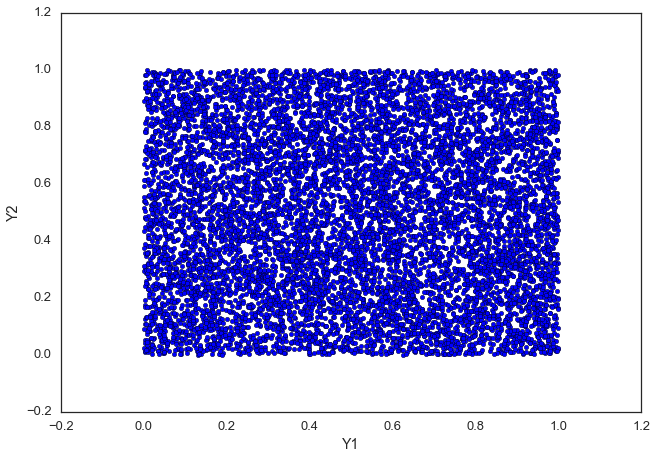

In [5]:
# sample two indipendent variates
Y1 = np.random.uniform(low=0, high=1, size=10000)
eplison = np.random.uniform(low=0, high=1, size=10000)

# our correlation weight
a = 0.0
# create Y2
Y2 = (a * Y1) + ((1-a) * eplison)

print "Variance of Y1: ", np.var(Y1)
print "Variance of Y2: ", np.var(Y2)
print "Correlation of Y1 and Y2: ", np.corrcoef(Y1,Y2)[0,1]

plt.scatter(Y1, Y2)
plt.xlabel("Y1")
plt.ylabel("Y2")
plt.show()

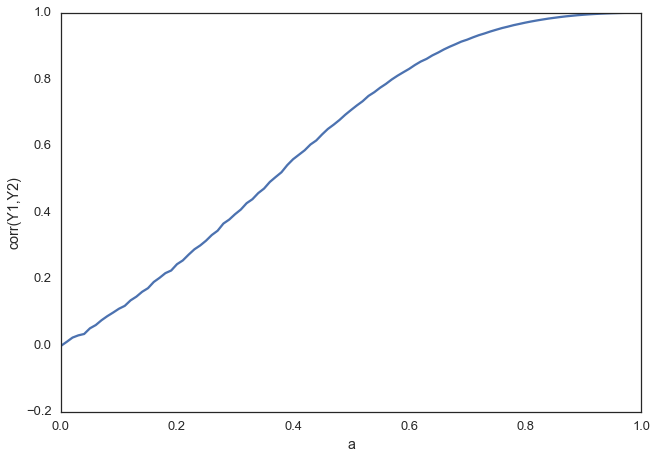

In [6]:
correlations = []
for a in np.arange(0.0,1.0,0.01):
    Y1 = np.random.uniform(low=0, high=1, size=100000)
    epsilon = np.random.uniform(low=0, high=1, size=100000)
    # correlation is non-linear with respect to a
    Y2 = a * Y1 + (1-a) * epsilon
    # this gives correlation linear to a
    #Y2 = a * Y1 + np.sqrt(1-a**2) * epsilon
    correlations.append(np.corrcoef(Y1,Y2)[0,1])
    
plt.plot(np.arange(0.0,1.0,0.01), correlations)
plt.xlabel("a")
plt.ylabel("corr(Y1,Y2)")
    

### Antithetic Variates Example:

In this example we are trying to calculate  the integral of $f(x) = \frac{1}{(x+1)}$ from $[0,1]$. To do so 
 we generate $X_1=U$ from a uniform distribution and $X_2=1-U$. Because $X_1,X_2$ are correlated,
 one can show that $Y_1=f(X_1),Y_2=f(X_2)$ are also strongly correlated if the function is monotonic.
 

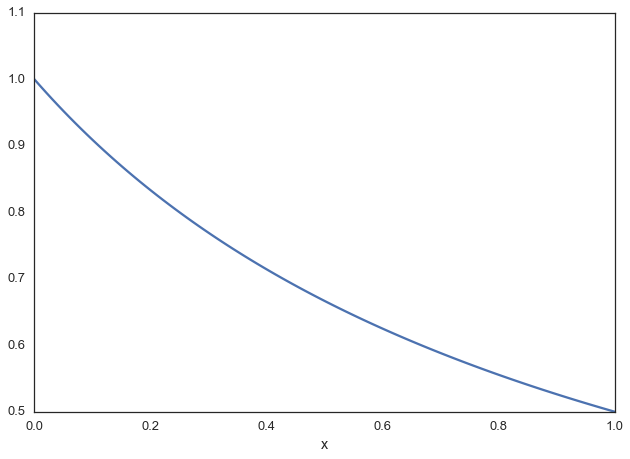

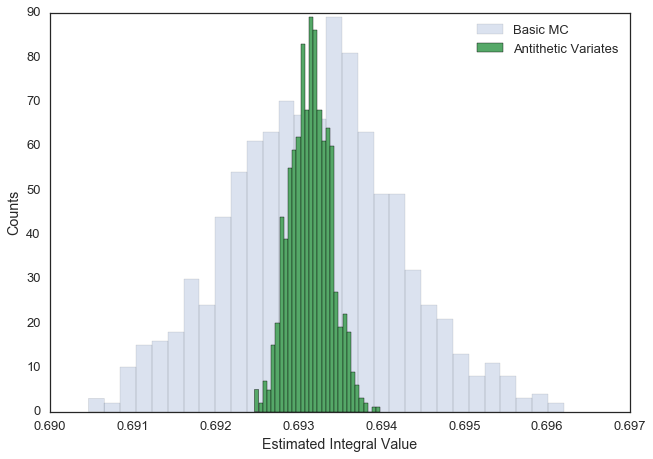

std dev of vanilla monte carlo:  0.00101060233458
std dev with antithetic variates:  0.000242904324366


In [13]:
# once again our number of samples
# and integral bounds
N =10000
xmin = 0 
xmax = 1


# ==============================
# DEFINE FUNCTIONS 
# ==============================
Y = lambda x:  1/(x+1)
intY = lambda x: np.log(x+1) 

# for testing
Iact = intY(xmax)-intY(xmin)

Ivmc=np.zeros(1000)
# I_anti_thetic
Iant=np.zeros(1000)

# plot the function
x = np.linspace(0,1,100)
plt.plot(x, Y(x), label=u'$1/(x+1)$')
plt.xlabel("x")
plt.show()

# ==============================
# GENERATING THE SAMPLE X1, X2 iid 
# and X1 amd Y1 negatively correlated 
# ==============================
for k in np.arange(0,1000):
    U = np.random.uniform(low=0, high=1, size=2*N)
    X=U

    # ==============================
    # VANILLA MC
    # ==============================
    Ivmc[k] =  np.mean(Y(X))

    # ==============================
    # ANTITHETIC MC
    # ==============================
    U = np.random.uniform(low=0, high=1, size=N) 
    X1 = U
    X2 = 1-U
    Iant[k] = 0.5*( np.mean(Y(X1))+np.mean(Y(X2)))

# -----------------------------
# VISUALIZE THE IMPROVEMENT
# -----------------------------
plt.hist(Ivmc,30, alpha=0.2, label=u'Basic MC');
plt.hist(Iant,30, label = u'Antithetic Variates');
plt.xlabel("Estimated Integral Value")
plt.ylabel("Counts")
plt.legend()
plt.show()

print "std dev of vanilla monte carlo: ", np.std(Ivmc)
print "std dev with antithetic variates: ", np.std(Iant)

### Stratification Example:

For a  one-dimensional application we take $ x/(x^2+1)$ and integrate from $[0,10]$.
We break $[0,10]$ into $M$ strata and for each stratum, take $N/M$ samples
with uniform probability distribution. Compute the average within each 
stratum, and then calculate the overall average. 

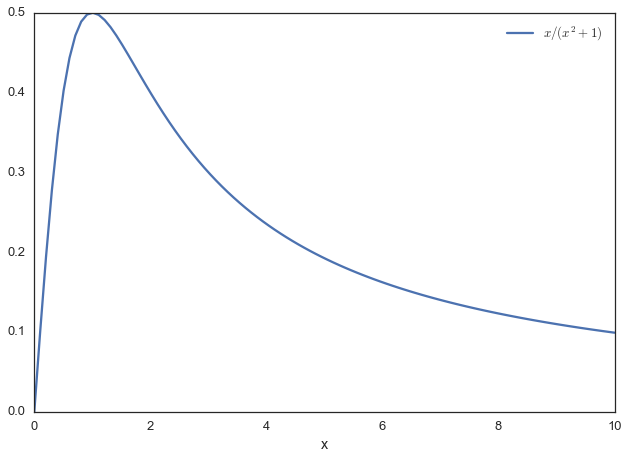

In [18]:
# Function definitions
Y = lambda x: x/(x**2+1.0);
intY = lambda x: np.log(x**2 + 1.0)/2.0;

## Ploting the original functions 
x = np.linspace(0,10,100)
plt.plot(x, Y(x), label=u'$x/(x^2+1)$')
plt.xlabel('x')
plt.legend()
plt.show()

C:\Users\vkaynig\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


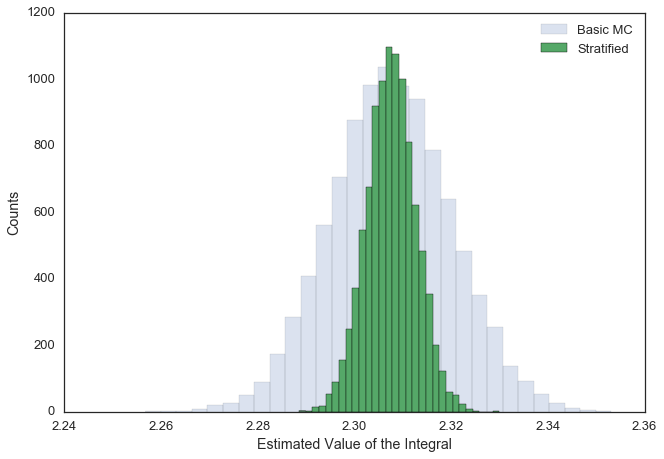

std dev of vanilla monte carlo:  0.0124742068807
std dev with stratification:  0.00511064599345


In [19]:
# number of samples
N = 10000 
# number of strata
M = 10   

# bounds of our integral
xmin = 0
xmax = 10

# analytic solution 
Ic = intY(xmax)-intY(xmin)

# I_monte_carlo
Imc = np.zeros(N)
# I_stratified
Is = np.zeros(N)

for k in np.arange(0,N):
    # range of our uniform distribution
    # whole range for vanilla
    Umin = 0
    Umax = 10
    
    # First lets do vanilla Monte Carlo.
    U = np.random.uniform(low=Umin, high=Umax, size=N)
    Imc[k] = (Umax-Umin)* np.mean(Y(U))

    # Now stratified with M regions
    step = (Umax-Umin )/M
    Umin = 0 
    Umax = step
    # Ii sums up our results
    Ii = 0
    
    # loop over all strata
    for reg in np.arange(0,M):
        # sample for this stratum
        x = np.random.uniform(low=Umin, high=Umax, size=1.0*N/M);
        # update Ii with the additional stratum data
        Ii = Ii+(Umax-Umin)* np.mean(Y(x))
        # update bounds for next stratum
        Umin = Umin + step
        Umax = Umin + step
        
    #save stratified result from this iteration
    Is[k] = Ii

# visualize the improvement
plt.hist(Imc,30, alpha=0.2, label=u'Basic MC');
plt.hist(Is,30, label = u'Stratified');
plt.xlabel("Estimated Value of the Integral")
plt.ylabel("Counts")
plt.legend()
plt.show()

print "std dev of vanilla monte carlo: ", np.std(Imc)
print "std dev with stratification: ", np.std(Is)